In [183]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Skin-Detection

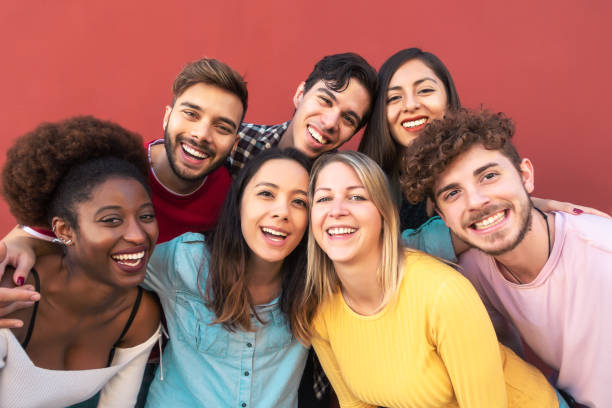

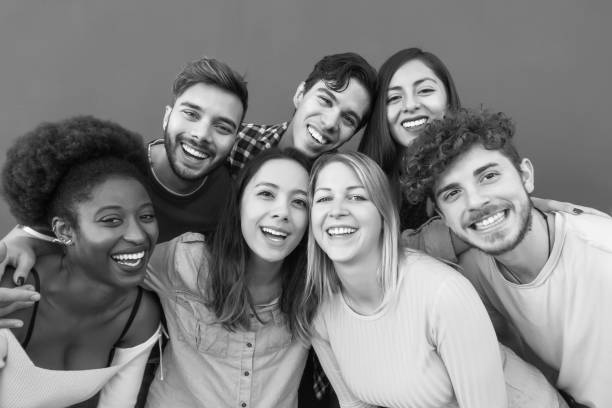

In [266]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
#Open a simple image
img=cv2.imread("drive/MyDrive/group.jpg")
cv2_imshow(img)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY);
cv2_imshow(gray)
#converting from gbr to hsv color space

img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#skin color range for hsv color space 
HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

#converting from gbr to YCbCr color space
img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
#skin color range for YCbCr color space 
YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135))
YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

#merge skin detection (YCbCr and hsv)
global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
global_mask=cv2.medianBlur(global_mask,3)
global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))


HSV_result = cv2.bitwise_not(HSV_mask)
YCrCb_result = cv2.bitwise_not(YCrCb_mask)
global_result=cv2.bitwise_not(global_mask)

#cv2.imwrite("1_HSV.jpg",HSV_result)
#cv2.imwrite("2_YCbCr.jpg",YCrCb_result)
#cv2.imwrite("3_global_result.jpg",global_result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()  
# cv2.waitKey(0)

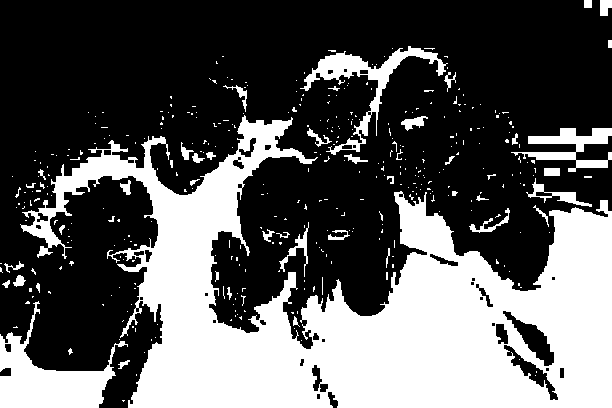

In [267]:
img=HSV_result
cv2_imshow(img)


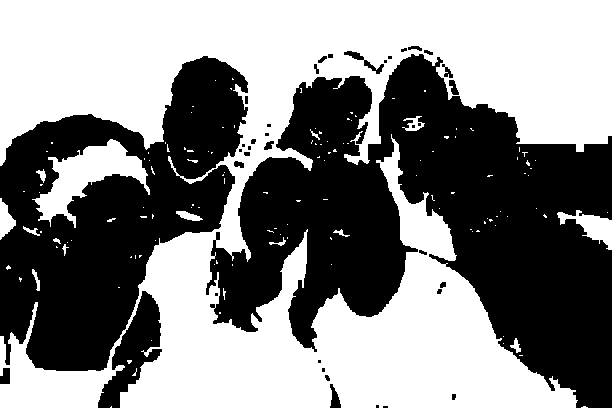

In [268]:
img=YCrCb_result
cv2_imshow(img)

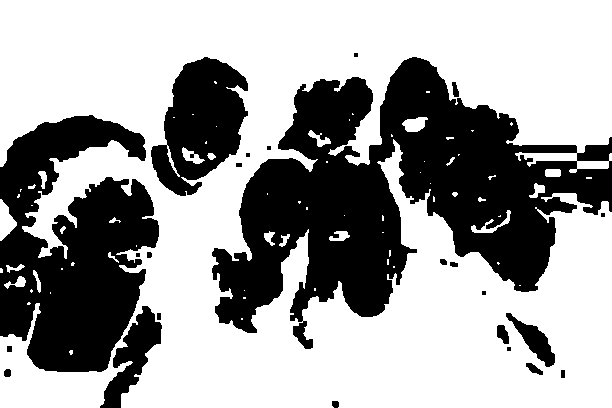

In [269]:
img=global_result
cv2_imshow(img)

# Hole Filling

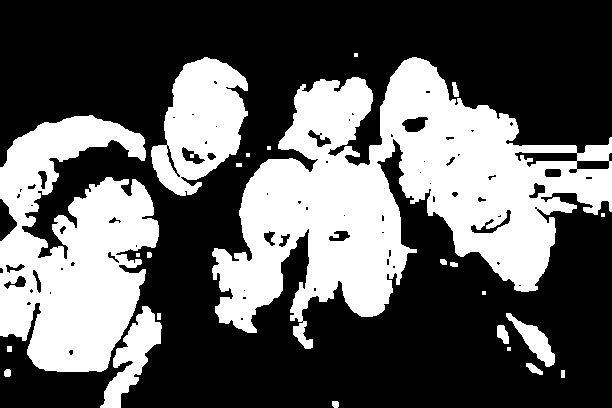

After Hole Filling....


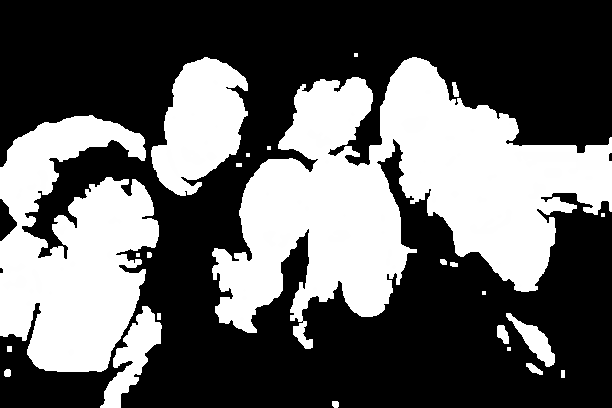

In [270]:
def FillHole(mask):
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    len_contour = len(contours)
    contour_list = []
    for i in range(len_contour):
        drawing = np.zeros_like(mask, np.uint8)  # create a black image
        img_contour = cv2.drawContours(
            drawing, contours, i, (255, 255, 255), -1)
        contour_list.append(img_contour)
        
    out = sum(contour_list)
    return out

img=global_result
inv = cv2.bitwise_not(img)
inv = np.asarray(inv,dtype=np.uint8)
cv2_imshow(inv)
# define a threshold, 128 is the middle of black and white in grey scale
thresh = 128

# threshold the image

img_binary = cv2.threshold(inv, thresh, 255, cv2.THRESH_BINARY)[1]
mask_out = FillHole(img_binary)
print("After Hole Filling....")
cv2_imshow(mask_out)



# Largest Connected Component

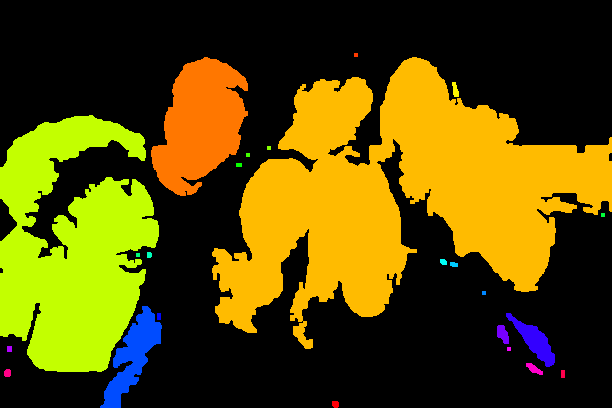

In [271]:
import cv2
import numpy as np

img = mask_out
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
num_labels, labels_im = cv2.connectedComponents(img)


#cv2_imshow(labels_im)
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    cv2_imshow(labeled_img)
    cv2.waitKey()

imshow_components(labels_im)

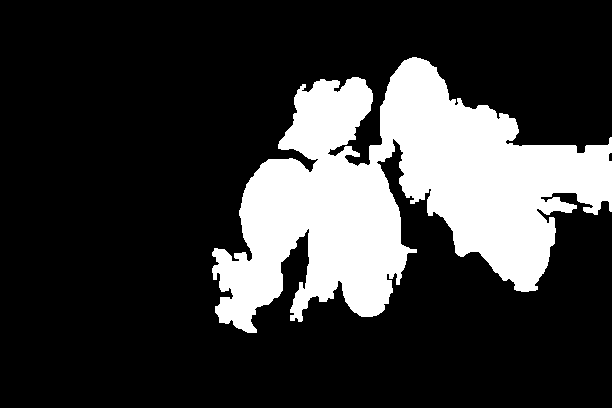

In [272]:
def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = 3000 #find component of size >3000
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    cv2_imshow(img2)
    # cv2.waitKey()
    return img2
connected_Comp = undesired_objects(mask_out)

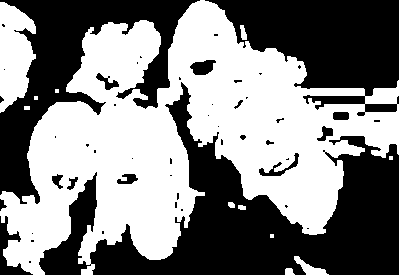

(275, 399)


dtype('uint8')

In [273]:
def crop(image):
    # y_nonzero -> Implies to Rows Indexes , x_nonzero -> Implies to Columns Indexes : in which we r having our connected Component 
    y_nonzero, x_nonzero = np.nonzero(image)
    # we are getting connected Component from 'Inv' Image 
    # but if you Really wants to Get largest Component from Real image then
    # return real_img[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
    return inv[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

crop_Image = crop(connected_Comp)
y_nonzero, x_nonzero = np.nonzero(connected_Comp)
"""print("x: ",np.min(x_nonzero))
print("x: ",np.max(x_nonzero))
print("y: ",np.min(y_nonzero))
print("y: ",np.max(y_nonzero))
"""
cv2_imshow(crop_Image)
print(crop_Image.shape)
crop_Image.dtype

# DWT

Crop image Shape :  (275, 399)
Subband Shape :  (138, 200)
cA


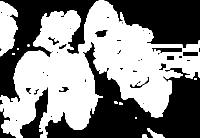

cH


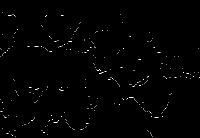

cV


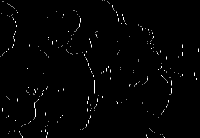

cD


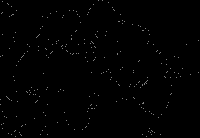

In [274]:
import pywt
print("Crop image Shape : ",crop_Image.shape)

# after applying DWT dimensions of all Subbands = 1/2(crop image)
coeffs = pywt.dwt2(crop_Image, 'haar')
cA, (cH, cV, cD) = coeffs

print("Subband Shape : ",cA.shape)

print("cA")
cv2_imshow(cA)
print("cH")
cv2_imshow(cH)
print("cV")
cv2_imshow(cV)
print("cD")
cv2_imshow(cD)


{'cH': 0.2401806212916156, 'cV': 0.2968289217168125, 'cD': 0.17307122502997255}
Max entropy is of Band :  cV


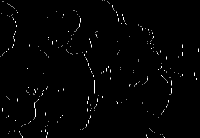

In [275]:
import skimage.measure
# Dict = {'entropy_cA' : skimage.measure.shannon_entropy(cA),'entropy_cH' : skimage.measure.shannon_entropy(cH),'entropy_cV' : skimage.measure.shannon_entropy(cV),'entropy_cD' : skimage.measure.shannon_entropy(cD)}
# entropy_cA = skimage.measure.shannon_entropy(cA)
# entropy_cH = skimage.measure.shannon_entropy(cH)
# entropy_cV = skimage.measure.shannon_entropy(cV)
# entropy_cD = skimage.measure.shannon_entropy(cD)
# print("Entropy cA : ",entropy_cA)
# print("Entropy cH : ",entropy_cH)
# print("Entropy cV : ",entropy_cV)
# print("Entropy cD : ",entropy_cD)
# print("Max Entropy is : " , max(entropy_cA,entropy_cH,entropy_cV,entropy_cD))

# Dict = {'cA' : skimage.measure.shannon_entropy(cA),'cH' : skimage.measure.shannon_entropy(cH),'cV' : skimage.measure.shannon_entropy(cV),'cD' : skimage.measure.shannon_entropy(cD)}

# We are Measuring Entropy of Each subband using Library (we could also calculate it using a Custom function)
# Entropy R = − sum (x.*log2(x)) => Where x is histogram count of grayscale sub-band
Dict = {'cH' : skimage.measure.shannon_entropy(cH),'cV' : skimage.measure.shannon_entropy(cV),'cD' : skimage.measure.shannon_entropy(cD)}
print(Dict)

# find Maximum from Dictionary
Keymax = max(zip(Dict.values(), Dict.keys()))[1]
print("Max entropy is of Band : ",Keymax)
if(Keymax == 'cH'):
  maxEntropy_Band = cH
elif(Keymax == 'cV'):
  maxEntropy_Band = cV
elif(Keymax == 'cD'):
  maxEntropy_Band = cD

cv2_imshow(maxEntropy_Band)


In [276]:
max_value = np.amax(maxEntropy_Band)
min_value = np.amin(maxEntropy_Band)
print("Max:",max_value)
print("Min:",min_value)

Max: 255.00000000000003
Min: -255.00000000000003


### Here idwt_img is type of float64 but for merging it with inv(real Binary image) we have to convert float64 to uint8

# Generate Pairs using SEED


In [315]:
import random
from random import randint
def generate_Coordinates(m, n , length):
    random.seed(length)
    seen = set()
    x, y = randint(1, m), randint(1, n)
    while len(seen) < length :
        while (x, y) in seen:
            x, y = randint(1, m), randint(1, n)
        seen.add((x, y))
    return seen

# Getting total Rows & Columns in which we are gonna hide Message
row,col = maxEntropy_Band.shape
# row , col = 400,500
string = "This is a Secret Message.My name is munaf divan i am student at DDU. I am currently in the 6th semester."

# Converting String's Character stream to Binary Stream
binary = ''.join(format(i, '08b') for i in bytearray(string, encoding ='utf-8'))
# print("Binary : ",binary)

# Getting Coordinates in which we wants to HIDE message 0
coordinates = generate_Coordinates(row-1,col-1,len(binary))
print(coordinates)

{(108, 181), (133, 106), (113, 189), (82, 101), (8, 63), (41, 23), (4, 173), (47, 134), (61, 195), (114, 31), (72, 92), (58, 19), (86, 181), (63, 42), (61, 38), (17, 165), (119, 165), (81, 9), (11, 171), (86, 22), (102, 92), (123, 132), (63, 30), (10, 194), (70, 68), (115, 144), (95, 68), (55, 139), (89, 12), (24, 163), (90, 11), (45, 104), (108, 74), (118, 129), (107, 108), (43, 167), (3, 185), (101, 101), (119, 31), (32, 25), (91, 179), (116, 32), (122, 63), (53, 73), (82, 144), (25, 103), (102, 87), (49, 89), (45, 28), (86, 166), (57, 142), (111, 188), (78, 67), (8, 120), (107, 41), (126, 156), (17, 117), (15, 178), (24, 33), (14, 84), (119, 103), (31, 171), (28, 63), (18, 140), (29, 62), (104, 97), (75, 124), (112, 154), (104, 7), (84, 143), (81, 123), (86, 32), (39, 35), (117, 181), (77, 88), (131, 54), (133, 145), (66, 84), (97, 18), (13, 6), (83, 99), (122, 10), (21, 198), (118, 92), (137, 184), (2, 142), (36, 107), (120, 127), (49, 133), (27, 186), (64, 143), (137, 130), (10, 7

In [278]:
# # Convert Binary Data to String (for Extraction Part)

# ascii_string = ''.join(chr(int(binary[i*8:i*8+8],2)) for i in range(len(binary)//8))

# print("String After Binary Conversion : ", ascii_string)
 

# Embedd Modified Component into Real Image



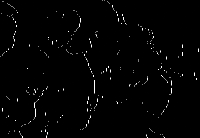

832


In [316]:
import math
# this will Hide the Message into Perticular Subband
modified_maxEntropy_Band = np.copy(maxEntropy_Band)
i = 0
for x,y in coordinates:
    # print("x,y : " , x , y , " :: Pixel Value :-> ", maxEntropy_Band[x,y])
    fract_pixel, int_pixel = math.modf(maxEntropy_Band[x, y])
    # int_pixel = int((maxEntropy_Band[x, y]))
    bin_pixel = bin(int(int_pixel))
    # fract_pixel, whole = math.modf(maxEntropy_Band[x, y])

    # print("Integer Pixel : ", int_pixel, " , Fractional Pixel : ", fract_pixel)

    new_bin_pixel = list(bin_pixel)
    new_bin_pixel[len(bin_pixel) - 1] = binary[i]
    bin_pixel = "".join(new_bin_pixel)

    int_pixel = int(bin_pixel, 2)
    modified_maxEntropy_Band[x, y] = int_pixel + fract_pixel
    # print("Binary = ", binary[i], " #  maxEntropy_Band[x, y] => ",  maxEntropy_Band[x, y] ,"\n")

    # if(maxEntropy_Band[x,y] <= 0):
    #     # if (maxEntropy_Band[x, y] % 2 == 0) :
    #     #     print("even ")
    #     # else :
    #     #     print("odd")

    #     # maxEntropy_Band[x,y] =  maxEntropy_Band[x,y] + binary[i]
    #     # bin(int((maxEntropy_Band[x, y])))

    #     # bin_pixel[len(bin_pixel) - 1] = binary[i] # for Performing that

    #     new_bin_pixel = list(bin_pixel)
    #     new_bin_pixel[len(bin_pixel) - 1] = binary[i]
    #     bin_pixel = "".join(new_bin_pixel)

    #     fract_pixel = maxEntropy_Band[x,y] - int_pixel 

    #     # print(fract_pixel)
    #     int_pixel = int(bin_pixel, 2);
    #     maxEntropy_Band[x,y] = int_pixel + fract_pixel
    #     print("Binary = ", binary[i], " <> ", maxEntropy_Band[x, y])
    # else:
    #     # if (maxEntropy_Band[x, y] % 2 == 0):
    #     #     print("even")
    #     # else :
    #     #     print("odd")

    #     # bin_pixel[len(bin_pixel) - 1] = binary[i]

    #     # maxEntropy_Band[x, y] = maxEntropy_Band[x,y] - binary[i]
    # # print(int_pixel , bin_pixel)
    i = i+1

cv2_imshow(modified_maxEntropy_Band)

# cv2.waitKey(0)
# cv2.destroyAllWindows()
print(i)

##Applying IDWT with Modified sub-band

equal_arrays_cV


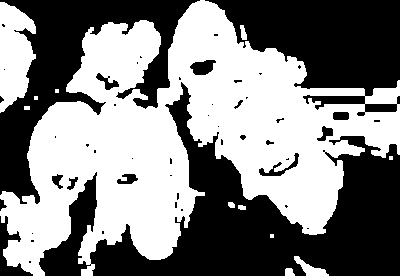

In [317]:
# It's Gonna Make Crop image using IDWT (embedding side)
comparison = maxEntropy_Band == cH
equal_arrays_cH= comparison.all()
comparison = maxEntropy_Band == cV
equal_arrays_cV = comparison.all()
comparison = maxEntropy_Band == cD
equal_arrays_cD = comparison.all()

if(equal_arrays_cH):
    print("equal_arrays_cH")
    modified_cH = modified_maxEntropy_Band
    modified_coeffs = cA , (modified_cH,cV,cD)
elif(equal_arrays_cV):
    print("equal_arrays_cV")
    modified_cV = modified_maxEntropy_Band
    modified_coeffs = cA, (cH, modified_cV, cD)
elif(equal_arrays_cD):
    print("equal_arrays_cD")
    modified_cD = modified_maxEntropy_Band
    modified_coeffs = cA, (cH, cV, modified_cD)

# Applying Invers IDWT (Embedding Side)
idwt_img =pywt.idwt2(modified_coeffs, 'haar')
cv2_imshow(idwt_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [318]:
print(np.unique(idwt_img))

[-5.00000000e-01 -5.00000000e-01  0.00000000e+00  2.84217094e-14
  5.00000000e-01  5.00000000e-01  5.00000000e-01  5.00000000e-01
  2.54500000e+02  2.55000000e+02  2.55000000e+02  2.55500000e+02
  2.55500000e+02]


##Seperating Intger and Fractional part of the modified ROI

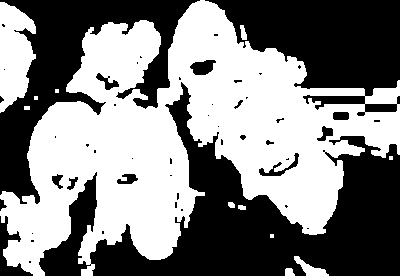

In [319]:
# See if it works or not !!! i did my best Though 😙
import math
rows,cols = idwt_img.shape
int_idwt_img = np.empty((rows, cols), np.uint8)
fract_idwt_img = np.empty((rows, cols), np.float64)

for x in range(0, rows):
    for y in range(0, cols):
        fract_pixel, int_pixel = math.modf(idwt_img[x, y])
        if(int_pixel >= 0):
            int_idwt_img[x,y] = int_pixel
            fract_idwt_img[x,y] = fract_pixel
        else:
            int_idwt_img[x, y] = abs(int_pixel)
            fract_idwt_img[x,y] = -fract_pixel

cv2_imshow(int_idwt_img)

##Merging Modified ROI into binary image

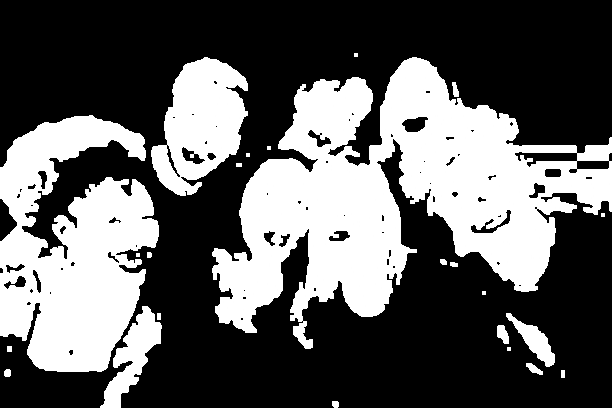

In [320]:
modified_inv = inv
# i = int(0)
# j = int(0)
# for (x,y) in zip(x_nonzero,y_nonzero):
#     modified_inv[x, y] = int_idwt_img[i, j]
#     i = i + 1
#     j = j + 1
#print(int_idwt_img)
#print("Crop Shape: ", crop_Image.shape)
#print("int_idwt_img Shape: ",int_idwt_img.shape)
y_nonzero, x_nonzero = np.nonzero(connected_Comp)
x = np.min(x_nonzero)
y = np.min(y_nonzero)
modified_inv[y:y+int_idwt_img.shape[0], x:x+int_idwt_img.shape[1]] = int_idwt_img

cv2_imshow(modified_inv)
ROI = modified_inv[np.min(y_nonzero):np.max(y_nonzero),np.min(x_nonzero):np.max(x_nonzero)]
#cv2.imshow("crop Image", crop_Image)
#cv2.imshow("int_idwt_img", fract_idwt_img)
#cv2.waitKey(0)
# cv2.destroyAllWindows()



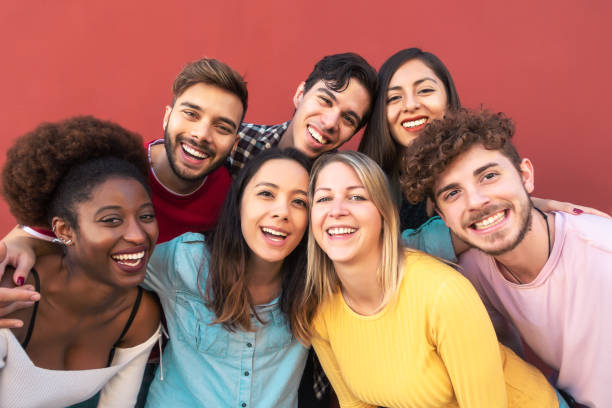

In [321]:
img=cv2.imread("drive/MyDrive/group.jpg")
cv2_imshow(img)

##Hiding Modified binary image into R plane of Original image

In [322]:
#This Code Hides image inside an image using 2-LSB

def encode(image_to_hide, image_to_hide_in):
    
    width, height = image_to_hide_in.shape
    
    for y in range(height):
        for x in range(width):
            try:
              value = image_to_hide[x,y]
              pixel = image_to_hide_in[x,y]
              #print("value: ",value)
              #print("pixel: ",pixel)
              bin_pixel = bin(int(pixel))
              #print("binary: ",len(new_bin_pixel))
              new_bin_pixel = list(bin_pixel)
              if value == 0:
                new_bin_pixel[len(bin_pixel) - 2] = '0'
                new_bin_pixel[len(bin_pixel) - 1] = '0'
              elif value == 1:
                new_bin_pixel[len(bin_pixel) - 2] = '0'
                new_bin_pixel[len(bin_pixel) - 1] = '1'
              elif value == 254:
                new_bin_pixel[len(bin_pixel) - 2] = '1'
                new_bin_pixel[len(bin_pixel) - 1] = '0'
              elif value == 255:
                new_bin_pixel[len(bin_pixel) - 2] = '1'
                new_bin_pixel[len(bin_pixel) - 1] = '1'
              
              bin_pixel = "".join(new_bin_pixel)
              int_pixel = int(bin_pixel, 2)
              image_to_hide_in[x, y] = int_pixel
            except Exception as e:
                print(e.args)

    #return an Image object from the above data.
    return image_to_hide_in

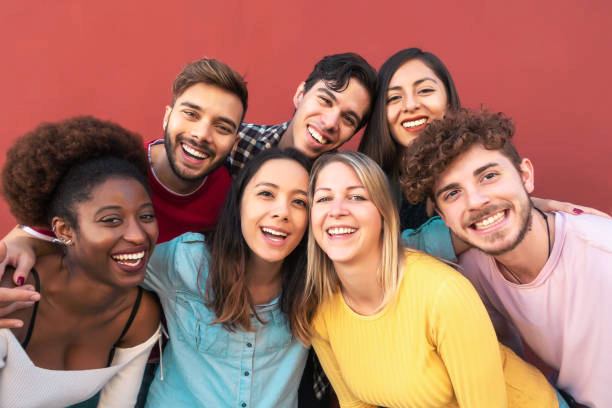

In [323]:
#Splitting R,G,B planes
(B, G, R) = cv2.split(img)

#hiding an image inside R-Plane using 2-LSB
modified_R = encode(modified_inv,R)

#Getting color image back by merging modified_R,G,B planes
stego_image = cv2.merge([B, G, modified_R])
cv2_imshow(stego_image)

#Receiver Side

In [324]:
#This code retrives image from an image using 2-LSB

def decode(combine_img):
    
    width, height = combine_img.shape
    hidden_img = np.zeros_like(modified_R,dtype='uint8')
    for y in range(height):
        for x in range(width):
            try:
              pixel = combine_img[x,y]
              #print("value: ",value)
              #print("pixel: ",pixel)
              bin_pixel = bin(int(pixel))
              #print("binary: ",len(new_bin_pixel))
              new_bin_pixel = list(bin_pixel)
              if new_bin_pixel[len(bin_pixel) - 2] == '0' and new_bin_pixel[len(bin_pixel) - 1] == '0':
                value = 0
              elif new_bin_pixel[len(bin_pixel) - 2] == '0' and new_bin_pixel[len(bin_pixel) - 1] == '1':
                value = 1
              elif new_bin_pixel[len(bin_pixel) - 2] == '1' and new_bin_pixel[len(bin_pixel) - 1] == '0':
                value = 254
              elif new_bin_pixel[len(bin_pixel) - 2] == '1' and new_bin_pixel[len(bin_pixel) - 1] == '1':
                value = 255
      
              hidden_img[x, y] = value
            except Exception as e:
                print(e.args)

    #return an Image object from the above data.
    return hidden_img

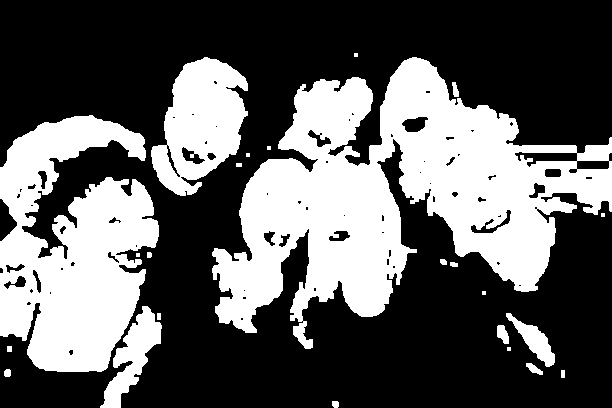

In [325]:
#Getting R-plane from stego image in which we hide binary image
(B,G,R) = cv2.split(stego_image)
decoded = decode(R)
cv2_imshow(decoded)

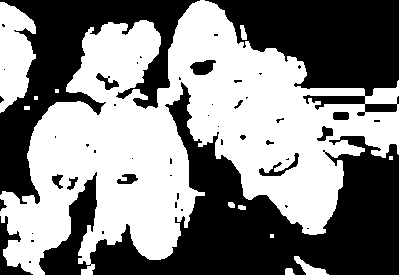

In [326]:
y_nonzero, x_nonzero = np.nonzero(connected_Comp)
ROI = decoded[np.min(y_nonzero):np.max(y_nonzero),np.min(x_nonzero):np.max(x_nonzero)]
cv2_imshow(ROI)

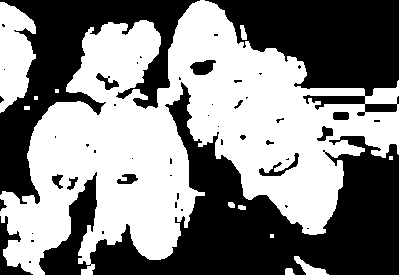

In [327]:
#combining fractional part which we extracted in embedding after idwt

width,height = ROI.shape
new_roi = np.zeros_like(ROI,dtype="float64")

for y in range(height):
  for x in range(width):
    fract = fract_idwt_img[x,y]
    if (fract<0):
      new_roi[x,y] = -(ROI[x,y] + abs(fract))
    else:
      new_roi[x,y] = ROI[x,y] + fract
cv2_imshow(new_roi)

rec_cA


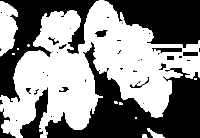

rec_cH


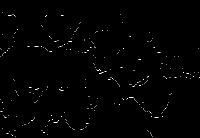

Rec_cV


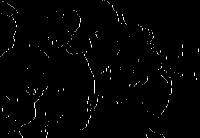

Rec_cD


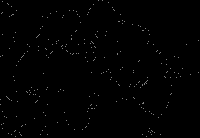

In [328]:
# it will do DWT of Modfied IDWT of Embedding side(it's in a Extracting Side)

rec_coeffs = pywt.dwt2(new_roi, 'haar')
rec_cA, (rec_cH, rec_cV, rec_cD) = rec_coeffs
print("rec_cA")
cv2_imshow(rec_cA)
print("rec_cH")
cv2_imshow(rec_cH)
print("Rec_cV")
cv2_imshow(rec_cV)
print("Rec_cD")
cv2_imshow(rec_cD)

# cv2.waitKey(0)
# cv2.destroyAllWindows()


{'rec_cH': 0.26184566869645304, 'rec_cV': 0.433673526998725, 'rec_cD': 0.1947929078126385}
Max entropy is of Band :  rec_cV
Max Entropy Band


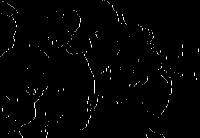

In [329]:
# This will find the maxEntropy on Reciver Side
import skimage.measure
# Dict = {'entropy_cA' : skimage.measure.shannon_entropy(cA),'entropy_cH' : skimage.measure.shannon_entropy(cH),'entropy_cV' : skimage.measure.shannon_entropy(cV),'entropy_cD' : skimage.measure.shannon_entropy(cD)}
# entropy_cA = skimage.measure.shannon_entropy(cA)
# entropy_cH = skimage.measure.shannon_entropy(cH)
# entropy_cV = skimage.measure.shannon_entropy(cV)
# entropy_cD = skimage.measure.shannon_entropy(cD)
# print("Entropy cA : ",entropy_cA)
# print("Entropy cH : ",entropy_cH)
# print("Entropy cV : ",entropy_cV)
# print("Entropy cD : ",entropy_cD)
# print("Max Entropy is : " , max(entropy_cA,entropy_cH,entropy_cV,entropy_cD))

# Dict = {'cA' : skimage.measure.shannon_entropy(cA),'cH' : skimage.measure.shannon_entropy(cH),'cV' : skimage.measure.shannon_entropy(cV),'cD' : skimage.measure.shannon_entropy(cD)}
rec_Dict = {'rec_cH' : skimage.measure.shannon_entropy(rec_cH),'rec_cV' : skimage.measure.shannon_entropy(rec_cV),'rec_cD' : skimage.measure.shannon_entropy(rec_cD)}
print(rec_Dict)
rec_Keymax = max(zip(rec_Dict.values(), rec_Dict.keys()))[1]
print("Max entropy is of Band : ",rec_Keymax)
# if(Keymax == 'cA'):
#   maxEntropy_Band = cA
if(rec_Keymax == 'rec_cH'):
  rec_maxEntropy_Band = rec_cH
elif(rec_Keymax == 'rec_cV'):
  rec_maxEntropy_Band = rec_cV
elif(rec_Keymax == 'rec_cD'):
  rec_maxEntropy_Band = rec_cD

print("Max Entropy Band")
cv2_imshow(rec_maxEntropy_Band)

# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [330]:
# Extracting Part Here
import math
# i = 0


message = []
for x,y in coordinates:
    # print("x,y : " , x , y , " :: Pixel Value :-> ", maxEntropy_Band[x,y])
    pixel = ((rec_maxEntropy_Band[x, y]))
    fract_pixel, int_pixel = math.modf(rec_maxEntropy_Band[x, y])
    bin_pixel = bin(int(int_pixel))
    # fract_pixel, whole = math.modf(maxEntropy_Band[x, y])
    message.append(bin_pixel[len(bin_pixel) - 1])
    # print("Integer Pixel : ", int_pixel, " , Fractional Pixel : ", fract_pixel)

    # new_bin_pixel = list(bin_pixel)
    # new_bin_pixel[len(bin_pixel) - 1] = binary[i]
    # bin_pixel = "".join(new_bin_pixel)

    # int_pixel = int(bin_pixel, 2)
    # maxEntropy_Band[x, y] = int_pixel + fract_pixel
    # print("Binary = ", binary[i], " #  maxEntropy_Band[x, y] => ",  maxEntropy_Band[x, y] ,"\n")

    # if(maxEntropy_Band[x,y] <= 0):
    #     # if (maxEntropy_Band[x, y] % 2 == 0) :
    #     #     print("even ")
    #     # else :
    #     #     print("odd")

    #     # maxEntropy_Band[x,y] =  maxEntropy_Band[x,y] + binary[i]
    #     # bin(int((maxEntropy_Band[x, y])))

    #     # bin_pixel[len(bin_pixel) - 1] = binary[i] # for Performing that

    #     new_bin_pixel = list(bin_pixel)
    #     new_bin_pixel[len(bin_pixel) - 1] = binary[i]
    #     bin_pixel = "".join(new_bin_pixel)

    #     fract_pixel = maxEntropy_Band[x,y] - int_pixel 

    #     # print(fract_pixel)
    #     int_pixel = int(bin_pixel, 2);
    #     maxEntropy_Band[x,y] = int_pixel + fract_pixel
    #     print("Binary = ", binary[i], " <> ", maxEntropy_Band[x, y])
    # else:
    #     # if (maxEntropy_Band[x, y] % 2 == 0):
    #     #     print("even")
    #     # else :
    #     #     print("odd")

    #     # bin_pixel[len(bin_pixel) - 1] = binary[i]

    #     # maxEntropy_Band[x, y] = maxEntropy_Band[x,y] - binary[i]
    # # print(int_pixel , bin_pixel)
    # i = i+1
print(message)
string_message = ''
for x in message:
    string_message += x

ascii_string = ''.join(chr(int(string_message[i*8:i*8+8], 2))  for i in range(len(string_message)//8))

print("String After Binary Conversion : ", ascii_string)


['0', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '1', '1', '0', '0', '1', '0', '1', '0', '1', '1', '0', '0', '0', '1', '1', '0', '1', '1', '1', '0', '0', '1', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '1', '0', '1', '1', '0', '0', '1', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0',